In [12]:
import pandas as pd
import csv  # Import the csv module
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Path to your CSV file
file_path = "/content/IMDB Dataset.csv"  # Adjust with the actual file path

# Read the CSV with additional parameters to handle quotes and escape characters
data = pd.read_csv(file_path, quoting=csv.QUOTE_MINIMAL, escapechar='\\')

# Display the first few rows
print(data.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [48]:
# Load dataset
texts = data['review']
labels = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)


In [49]:
# Preprocessing: Tokenization and Padding
tokenizer = Tokenizer(num_words=10000)  # Max vocab size
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [50]:
# Define max sequence length (this should be the max length after padding)
maxlen = 100
padded_sequences = pad_sequences(sequences, maxlen=maxlen)  # Max sequence length


In [51]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [79]:
# Vanilla RNN Model
# Vanilla RNN Model
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),  # Word embeddings
   SimpleRNN(128, return_sequences=False),   # Vanilla RNN layer
    #SimpleRNN(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3,
             # kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [80]:
# Compile the model
optimizer = Adam(learning_rate=0.0005)  # Adjusted learning rate
  # Learning rate can be tuned
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


In [81]:
# Learning Rate Scheduler that reduces the learning rate if validation loss plateaus
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)


In [82]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.5825 - loss: 0.6417 - val_accuracy: 0.8256 - val_loss: 0.3928
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.8681 - loss: 0.3233 - val_accuracy: 0.8541 - val_loss: 0.3435
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.9088 - loss: 0.2321 - val_accuracy: 0.8369 - val_loss: 0.3778
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.9435 - loss: 0.1559 - val_accuracy: 0.8320 - val_loss: 0.4307
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9735 - loss: 0.0807 - val_accuracy: 0.8374 - val_loss: 0.5307
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.9903 - loss: 0.0340 - val_accuracy: 0.8260 - val_loss: 0.6061
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8572 - loss: 0.3400
Test Accuracy: 85.64%


In [83]:
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(report)


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Confusion Matrix:
[[4150  811]
 [ 625 4414]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.84      0.85      4961
    Positive       0.84      0.88      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



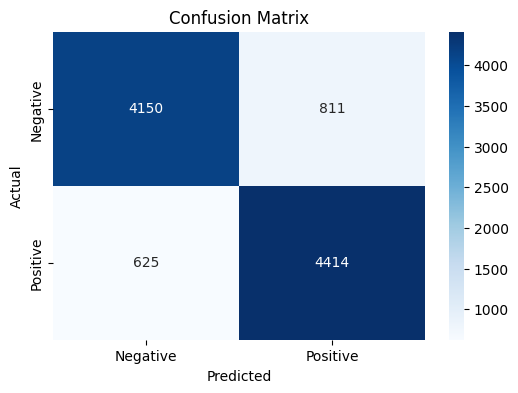

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [85]:
# Test reviews
test_reviews = [
    "The movie was a waste of time, very boring and dull.",  # Clearly negative
    "Absolutely loved the plot and acting, what a masterpiece!",  # Clearly positive
    "The movie was decent but had its flaws.",  # Mixed sentiment
    "Terrible direction but the actors tried their best.",  # Mixed with negative emphasis
    "It was neither good nor bad, just average."  # Neutral sentiment
]

# Predict sentiments
for review in test_reviews:
    seq = tokenizer.texts_to_sequences([review])
    padded = pad_sequences(seq, maxlen=maxlen)
    pred = model.predict(padded)[0][0]
    sentiment = "Positive" if pred > 0.5 else "Negative"
    confidence = pred * 100 if sentiment == "Positive" else (1 - pred) * 100
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.2f}%\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Review: The movie was a waste of time, very boring and dull.
Predicted Sentiment: Negative
Confidence: 99.21%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Review: Absolutely loved the plot and acting, what a masterpiece!
Predicted Sentiment: Positive
Confidence: 69.64%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Review: The movie was decent but had its flaws.
Predicted Sentiment: Negative
Confidence: 76.97%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Review: Terrible direction but the actors tried their best.
Predicted Sentiment: Negative
Confidence: 73.80%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Review: It was neither good nor bad, just average.
Predicted Sentiment: Negative
Confidence: 97.48%

